**BADS Hackathon**

*Group Members - Aadya Sood, Arvind Yadav, Gaurav Dixit, Radhika Swaroop, Yashasvee Singh*

# Data Preprocessing

In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro, chi2_contingency
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [142]:
dataset = pd.read_csv("Bank_Marketing_Data_Final.csv")
dataset.head()

,day,contact,pdays,customer_service_rating,job,marital,education,month,default,housing,...,app_downloaded,age,balance,duration,campaign,previous,credit_score,marketing_spend_eur,website_visits,y
0,5,unknown,-1,3,management,married,tertiary,may,no,yes,...,yes,58,2143,261,1,0,402,131.87,6,no
1,5,unknown,-1,5,technician,single,secondary,may,no,yes,...,yes,44,29,151,1,0,735,128.70,5,no
2,5,unknown,-1,4,entrepreneur,married,secondary,may,no,yes,...,yes,33,2,76,1,0,570,55.57,6,no
3,5,unknown,-1,1,blue-collar,married,unknown,may,no,yes,...,no,47,1506,92,1,0,406,277.07,7,no
4,5,unknown,-1,4,unknown,single,unknown,may,no,no,...,no,33,1,198,1,0,371,75.87,3,no


In [143]:
# Check for missing values
print(dataset.isnull().sum())

day                        0
contact                    0
pdays                      0
customer_service_rating    0
job                        0
marital                    0
education                  0
month                      0
default                    0
housing                    0
loan                       0
poutcome                   0
app_downloaded             0
age                        0
balance                    0
duration                   0
campaign                   0
previous                   0
credit_score               0
marketing_spend_eur        0
website_visits             0
y                          0
dtype: int64


In [144]:
# Separate features and target variables
X = dataset.drop('y', axis=1)
y = dataset['y'].map({'yes': 1, 'no': 0})  # Convert target to binary

In [145]:
# Handle categorical variables
# Binary variables for label encoding
binary_cols = ['default', 'housing', 'loan', 'app_downloaded']
# Target variable
dataset['y'] = dataset['y'].map({'yes': 1, 'no': 0})  # Label encode target

In [146]:
# Apply label encoding to binary variables
for col in binary_cols:
    labelencoder = LabelEncoder()
    dataset[col] = labelencoder.fit_transform(dataset[col])

In [111]:
# Multi-category variables for one-hot encoding
multi_cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

In [147]:
# Numerical columns
numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns.drop(['y'] + binary_cols)

In [148]:
# Check for rare categories and group if necessary
for col in multi_cat_cols:
    value_counts = dataset[col].value_counts(normalize=True)
    rare_cats = value_counts[value_counts < 0.01].index
    if len(rare_cats) > 0:
        print(f"Grouping rare categories in {col}: {rare_cats}")
        dataset[col] = dataset[col].where(~dataset[col].isin(rare_cats), 'other')

Grouping rare categories in job: Index(['unknown'], dtype='object', name='job')
Grouping rare categories in month: Index(['dec'], dtype='object', name='month')


In [149]:
# Separate features and target
X = dataset.drop('y', axis=1)
y = dataset['y']

In [150]:
# Preprocessing data
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_cols), ('bin', 'passthrough', binary_cols), ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), multi_cat_cols)]) # Binary cols already encoded

In [151]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [152]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    cm = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

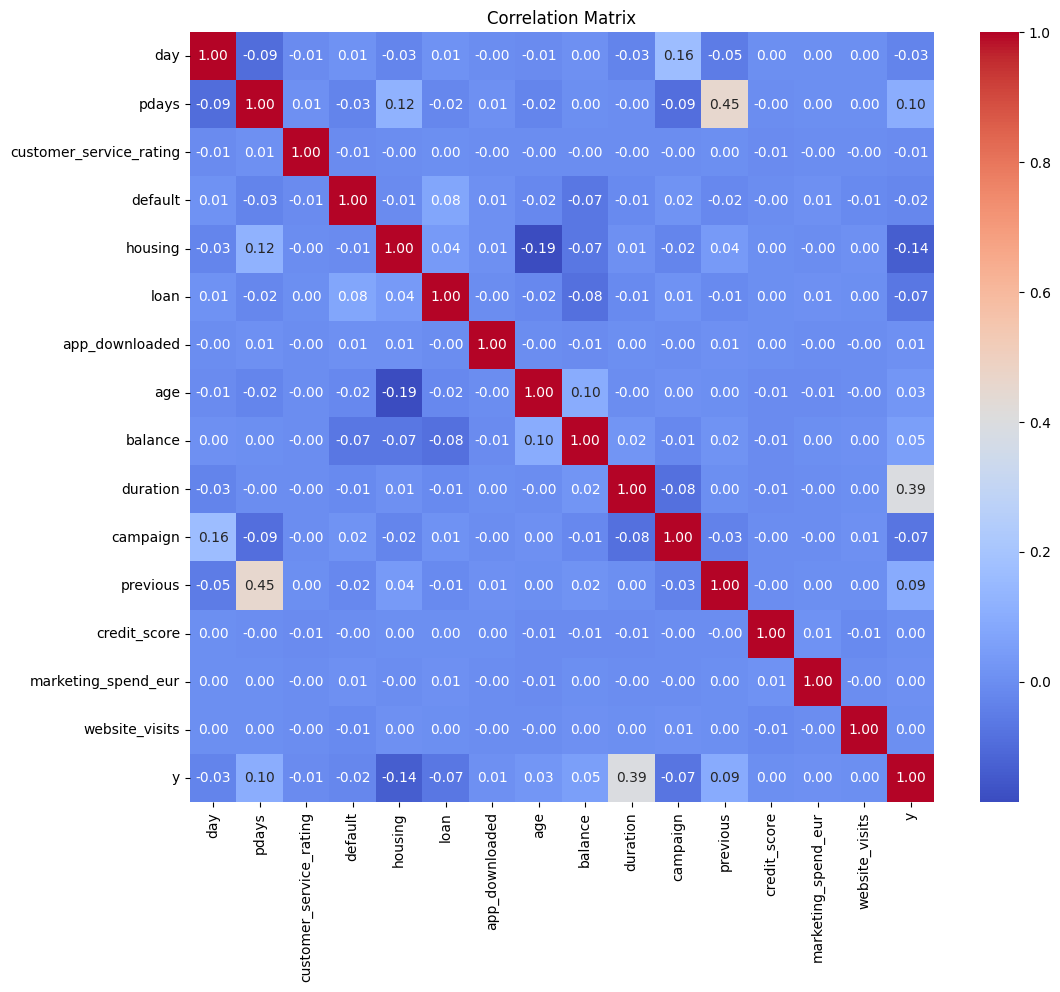

In [153]:
# Replace 'unknown' with NaN in the dataset
dataset = dataset.replace('unknown', np.nan)

# Calculate correlations only on numerical features
numerical_cols = dataset.select_dtypes(include=np.number).columns
corr_matrix = dataset[numerical_cols].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

***Variables Dropped and Why***

* **contact**: Dropped due to irrelevance of type of communication on the * target variable.

* **day**: Dropped as the specific day of contact adds little predictive value and introduces noise.

* **pdays**: Dropped because most values were -1, indicating no previous contact, reducing its usefulness.

* **Customer Service Rating**: Dropped due to low variance and minimal impact on target variable based on preliminary analysis.

# Naive Bayes


Naive Bayes Results:
Accuracy: 0.8641
Precision: 0.4290
Recall: 0.4887
F1 Score: 0.4569


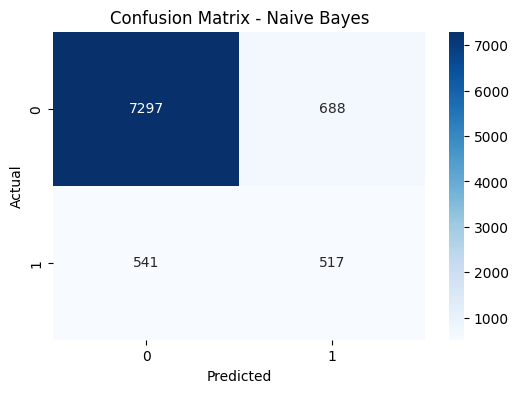

In [119]:
# Build the pipeline
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Applies all necessary preprocessing (e.g., scaling, encoding)
    ('classifier', GaussianNB())     # The classification model: Gaussian Naive Bayes
])

# Fit the model
nb_pipeline.fit(X_train, y_train)

nb_pred = nb_pipeline.predict(X_test) # This predicts hard class labels (0 or 1) using the default cutoff of 0.5
evaluate_model(y_test, nb_pred, "Naive Bayes")

# Classification and Regression Tree [CART]

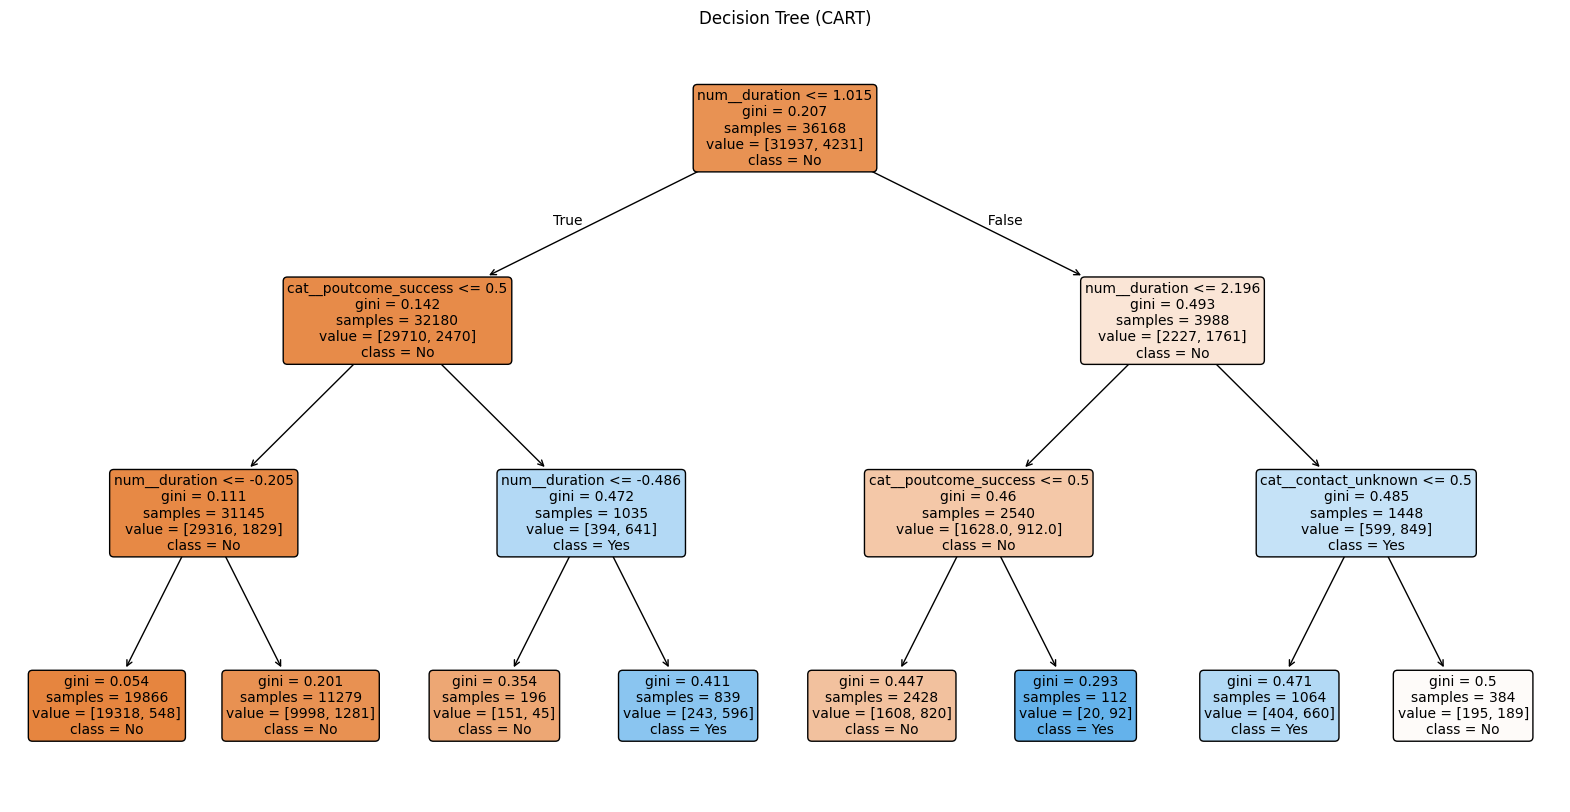


CART Results:
Accuracy: 0.8995
Precision: 0.6511
Recall: 0.3034
F1 Score: 0.4139


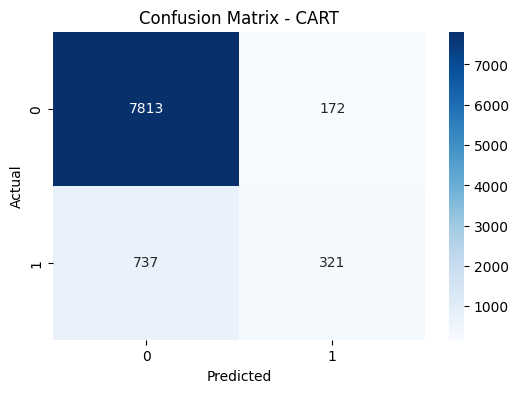

In [120]:
# Create a pipeline combining preprocessing and a decision tree classifier
cart_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Handles all data transformations (e.g., encoding, scaling)
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=3))  # CART model with limited depth for regularization
])

# Fit the pipeline on the training data
cart_pipeline.fit(X_train, y_train)

# Predict class labels on the test set
cart_pred = cart_pipeline.predict(X_test)

from sklearn.tree import plot_tree

# Extract the trained decision tree model from the pipeline
cart_model = cart_pipeline.named_steps['classifier']

# Plot the decision tree
plt.figure(figsize=(20, 10))  # You can adjust size as needed
plot_tree(cart_model,
          filled=True,              # Color nodes by class
          feature_names=preprocessor.get_feature_names_out(),  # Get processed feature names
          class_names=['No', 'Yes'],  # Assuming binary classification (e.g., 'no' and 'yes' subscription)
          rounded=True, fontsize=10)
plt.title("Decision Tree (CART)")
plt.show()

# Evaluate performance using a custom evaluation function
evaluate_model(y_test, cart_pred, "CART")

max_depth=3 is used to limit the depth of the decision tree, which helps prevent overfitting.
This value was chosen as a starting point based on initial experimentation or domain knowledge.
A deeper tree might lead to overfitting, while a shallower tree might underfit the data.
at max depth = 4, the accuracy was 89.96, while at 5 it was 89.86

#KNN


We used GridSearchCV to tune the n_neighbors parameter of the KNN model by testing values from 3 to 11 using 9-fold cross-validation. This helps identify the number of neighbors that gives the best accuracy on the training data. The optimal model is then selected for final evaluation.

In [121]:
param_grid = {'classifier__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11]}

In [122]:
from sklearn.model_selection import GridSearchCV

# Create the GridSearchCV object
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=9, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best n_neighbors: {best_params['classifier__n_neighbors']}")

Best n_neighbors: 9



KNN Results:
Accuracy: 0.8930
Precision: 0.6197
Recall: 0.2202
F1 Score: 0.3250


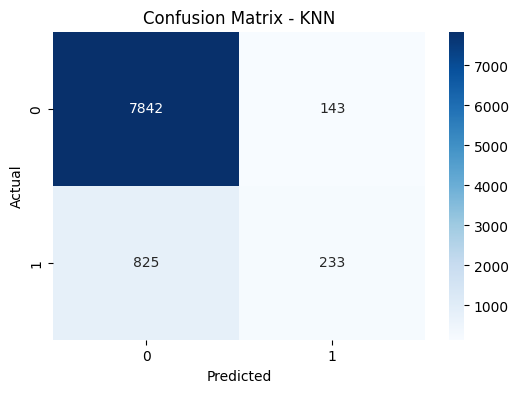

In [160]:
# Import the necessary class
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline # Make sure Pipeline is imported


# Create a pipeline with preprocessing and KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Your defined preprocessor
    ('classifier', KNeighborsClassifier(n_neighbors=9, metric='euclidean'))
])

# Train the pipeline
knn_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_pipeline.predict(X_test)

# Evaluate the model
evaluate_model(y_test, y_pred, "KNN")

# Deep Neural Network

In [162]:
# Preprocess data for DNN
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [163]:
# Build DNN
dnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Deep Neural Network Results:
Accuracy: 0.9079
Precision: 0.6408
Recall: 0.4839
F1 Score: 0.5514


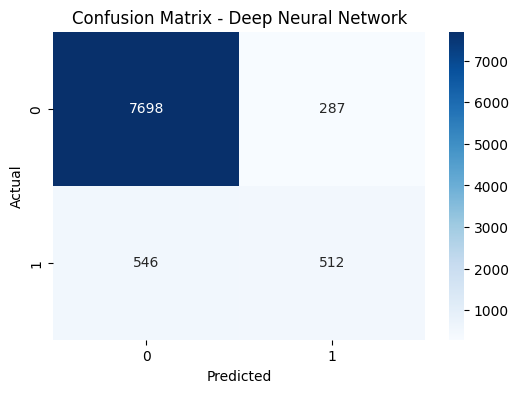

In [164]:
# Train DNN
dnn_model.fit(X_train_processed, y_train, epochs=50, batch_size=32, verbose=0)
dnn_pred = (dnn_model.predict(X_test_processed) > 0.5).astype(int).flatten()
evaluate_model(y_test, dnn_pred, "Deep Neural Network")

# Logistic Regression

**Logistic Regression Assumptions and Considerations - We have checked for them in the following code**


1. **Binary Dependent Variable:** Logistic regression is appropriate for binary classification problems. In this project, our target variable 'y' (whether the client subscribed to a term deposit) is indeed binary ('yes' or 'no'), satisfying this requirement.

2. **Independence of Observations:** We know that the observations in our dataset are independent of each other. This means that the outcome for one client is not influenced by or related to the outcome for another. However, we acknowledge potential real-world scenarios (like marketing campaigns targeting specific demographics) which could introduce minor dependencies.

3. **Minimal Multicollinearity:** Multicollinearity occurs when independent variables are highly correlated. We've examined this using the Variance Inflation Factor (VIF) and dropped the 'age' feature due to a high VIF. Further analysis or data collection could help mitigate any remaining correlation concerns.

In [154]:
# Logistic Regression Assumptions
print("\nLogistic Regression Checks:")
# Binary outcome
if len(dataset['y'].unique()) == 2:
    print("  Binary Outcome: Satisfied")
else:
    raise ValueError("Target 'y' is not binary")

# Multicollinearity (VIF for numerical features)
X_num = dataset[numerical_cols].dropna()
vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_cols
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
print("\n  VIF for Numerical Features:")
print(vif_data)
if (vif_data['VIF'] > 10).any():
    print("    Warning: High multicollinearity detected in numerical features")



Logistic Regression Checks:
  Binary Outcome: Satisfied

  VIF for Numerical Features:
                    Feature        VIF
0                       day   4.453381
1                     pdays   1.511701
2   customer_service_rating   4.995129
3                   default   1.029117
4                   housing   2.294684
5                      loan   1.208736
6            app_downloaded   3.181183
7                       age  11.336604
8                   balance   1.229030
9                  duration   2.360875
10                 campaign   1.852433
11                 previous   1.345959
12             credit_score  10.098360
13      marketing_spend_eur   6.180934
14           website_visits   5.426234
15                        y   1.411363


Age was dropped from the logistic regression model due to a Variance Inflation Factor greater than 10, indicating high multicollinearity with other features, which could distort coefficient estimates.

In [158]:
# Get predicted probabilities
y_pred_prob = lr_pipeline.predict_proba(X)[:, 1]

# Calculate log odds
log_odds = np.log(y_pred_prob / (1 - y_pred_prob))

# Add log odds to your dataset
dataset['log_y'] = log_odds

In [156]:
# Linearity (simplified: correlation with target for numerical features)
print("\n  Linearity Check (Correlation with log_y):")
for col in numerical_cols:
    corr = dataset[col].corr(dataset['log_y'])
    print(f"    {col} vs. log_y: Correlation={corr:.4f}")
    if abs(corr) < 0.1:
        print(f"      Note: Weak linear relationship for {col}")


  Linearity Check (Correlation with log_y):
    day vs. log_y: Correlation=-0.0743
      Note: Weak linear relationship for day
    pdays vs. log_y: Correlation=0.2101
    customer_service_rating vs. log_y: Correlation=-0.0161
      Note: Weak linear relationship for customer_service_rating
    default vs. log_y: Correlation=-0.0498
      Note: Weak linear relationship for default
    housing vs. log_y: Correlation=-0.3420
    loan vs. log_y: Correlation=-0.1631
    app_downloaded vs. log_y: Correlation=0.0179
      Note: Weak linear relationship for app_downloaded
    age vs. log_y: Correlation=0.0325
      Note: Weak linear relationship for age
    balance vs. log_y: Correlation=0.1120
    duration vs. log_y: Correlation=0.6882
    campaign vs. log_y: Correlation=-0.2467
    previous vs. log_y: Correlation=0.1647
    credit_score vs. log_y: Correlation=0.0085
      Note: Weak linear relationship for credit_score
    marketing_spend_eur vs. log_y: Correlation=0.0153
      Note: Weak 

In [157]:
dataset = dataset.drop('age', axis=1)


Logistic Regression Results:
Accuracy: 0.9009
Precision: 0.6441
Recall: 0.3422
F1 Score: 0.4469


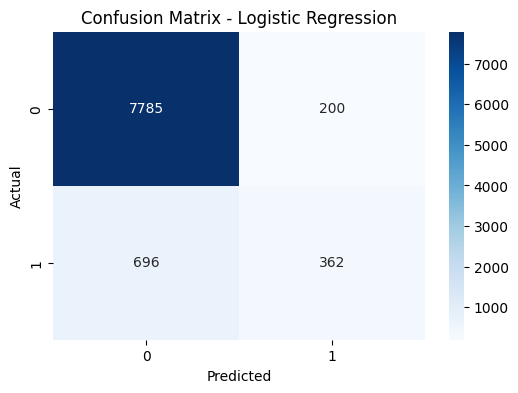

In [129]:
# Create a pipeline for logistic regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor), # Apply preprocessing transformations (e.g., encoding, scaling)
    ('classifier', LogisticRegression(random_state=42, max_iter=1000)) # Fit a logistic regression classifier
])

# Fit the pipeline on training data
lr_pipeline.fit(X_train, y_train)

lr_pred = lr_pipeline.predict(X_test)
evaluate_model(y_test, lr_pred, "Logistic Regression")